In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from load_cifar import load_data
import new_model as model


### Load dataset (cifar-10)

In [2]:
data = load_data('C:/Users/k_tej/Documents/TEJA/ML_resources/DL_projects/data_sets/cifar-10-batches-py')
#data = load_data('/floyd/input/cifar_10_batches_py/cifar-10-batches-py')

In [3]:
data.keys()

dict_keys(['train_x', 'train_y', 'test_x', 'test_y'])

In [4]:
(data['train_x'].shape,data['train_y'].shape),(data['test_x'].shape,data['test_y'].shape)

(((50000, 32, 32, 3), (50000,)), ((10000, 32, 32, 3), (10000,)))

### dataset labels

In [5]:
labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [6]:
DIM = 32
CH = 3

Label: truck


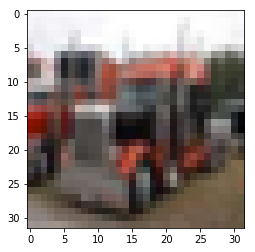

In [7]:
x = np.random.randint(50000)
print('Label: {}'.format(labels[data['train_y'][x]]))
plt.imshow(data['train_x'][x].reshape(DIM,DIM,CH))

### Data preprocessing

#### 1.  One hot encoding 

In [8]:
n_classes = 10
id_mtx = np.identity(n_classes,dtype=np.float32)
data['train_y'] = id_mtx[data['train_y']]
data['test_y'] = id_mtx[data['test_y']]
data['train_y'].shape, data['test_y'].shape

((50000, 10), (10000, 10))

#### 2. Normalize 

In [9]:
data['train_x'] = data['train_x'].astype(np.float32)/255
data['test_x'] = data['test_x'].astype(np.float32)/255

### generate datasets 

In [10]:
batch_size = 100

In [11]:
with tf.variable_scope("dataset_gen", reuse = tf.AUTO_REUSE ):    
    dtrain_x = tf.data.Dataset.from_tensor_slices(data['train_x'])
    dtrain_y = tf.data.Dataset.from_tensor_slices(data['train_y'])
    dtrain = tf.data.Dataset.zip(( dtrain_x, dtrain_y )).shuffle(batch_size).batch(batch_size)
    dtrain_one_shot = tf.data.Dataset.zip(( dtrain_x, dtrain_y )).batch(batch_size)
    
    dtest_x = tf.data.Dataset.from_tensor_slices(data['test_x'])
    dtest_y = tf.data.Dataset.from_tensor_slices(data['test_y'])
    dtest = tf.data.Dataset.zip(( dtest_x,dtest_y )).batch(batch_size)
    
    dvalid_x = tf.data.Dataset.from_tensor_slices(data['test_x'][:1000,:,:,:])
    dvalid_y = tf.data.Dataset.from_tensor_slices(data['test_y'][:1000])
    dvalid = tf.data.Dataset.zip(( dtest_x,dtest_y )).batch(batch_size)
(dtrain,dtest,dvalid)

(<BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>,
 <BatchDataset shapes: ((?, 32, 32, 3), (?, 10)), types: (tf.float32, tf.float32)>)

### Iterators 

In [12]:
with tf.variable_scope("dataset_init"):
    iterator = tf.data.Iterator.from_structure(dtrain.output_types,dtrain.output_shapes)
    get_batch = iterator.get_next()
    #for train
    dtrain_init = iterator.make_initializer(dtrain)
    #for test
    dtest_init = iterator.make_initializer(dtest)
    #for validation
    dvalid_init = iterator.make_initializer(dvalid)

### setting hyperparameters

In [13]:
epochs = 10  
probability_keep = 0.3

In [14]:
is_train = tf.placeholder(shape=(),dtype=tf.bool,name='is_train')
prob_keep = tf.placeholder(shape=(),dtype=tf.float32,name = 'probability_keep')
global_step = tf.Variable(0, trainable=False)
current_model = model.CNN(get_batch[0], is_train, prob_keep)
param_info = current_model.total_params()

varname : conv_1/weight:0 [Dimension(5), Dimension(5), Dimension(3), Dimension(32)]
varname : conv_1/bias:0 [Dimension(32)]
varname : conv_2/weight:0 [Dimension(5), Dimension(5), Dimension(32), Dimension(64)]
varname : conv_2/bias:0 [Dimension(64)]
varname : batch_normalization/gamma:0 [Dimension(3136)]
varname : batch_normalization/beta:0 [Dimension(3136)]
varname : dense/kernel:0 [Dimension(3136), Dimension(1024)]
varname : dense/bias:0 [Dimension(1024)]
varname : batch_normalization_1/gamma:0 [Dimension(1024)]
varname : batch_normalization_1/beta:0 [Dimension(1024)]
varname : dense_1/kernel:0 [Dimension(1024), Dimension(10)]
varname : dense_1/bias:0 [Dimension(10)]
varname : batch_normalization_2/gamma:0 [Dimension(10)]
varname : batch_normalization_2/beta:0 [Dimension(10)]
total number of trainable parameter : 3284574


In [15]:
logits=current_model.logits
logits

<tf.Tensor 'batch_normalization_2/batchnorm/add_1:0' shape=(?, 10) dtype=float32>

### Optimization 

In [16]:
start_lr = 1e-3
end_lr = 5e-3
decay_steps = 10000
lr = tf.train.exponential_decay(start_lr,global_step, decay_steps, 0.96, staircase=True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=get_batch[1],logits=logits))
tf.summary.scalar("losses",loss)
tf.summary.scalar("learning_rate",lr)
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    optimizer = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)
predictions = tf.argmax(logits,axis=1)
equality = tf.equal(predictions,tf.argmax(get_batch[1],axis=1))
accuracy = tf.reduce_mean(tf.cast(equality,tf.float32))
tf.summary.scalar("accuracy",accuracy)
ginit_op = tf.global_variables_initializer()

In [17]:
log_dir = 'floyd/home/logs'
print(log_dir)
t_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(log_dir)

floyd/home/logs


In [18]:
def run_dataset(sess, init_op, variables, feed_dict, train=False):
    sess.run(init_op)
    logs = []
    itr = 1
    stack = np.random.rand(1,n_classes)
    while True:
        try:
            res = sess.run(variables, feed_dict=feed_dict)
            logs.append(res[0]) # first element of the result is either accuracy or loss
            if train:
                writer.add_summary(res[-1],i)
                itr+=1
                if itr%100 == 0:
                    print("batch :{}, loss :{:.3f}, accuracy :{:.3f}".format(itr,res[0],res[2]))
            else:
                stack = np.vstack((stack,res[-1]))
        except tf.errors.OutOfRangeError:
            return logs,stack[1:]
            
    

In [19]:
valid_log_acc = []
train_log_acc=[]
test_acc=[]
train_acc=[]
with tf.Session() as sess:
    writer.add_graph(sess.graph)
    sess.run(ginit_op)
    train_log_loss = []
    valid_log_loss = []
    for i in range(1,epochs+1):
        print("training epoch : {}".format(i))
        sess.run(dtrain_init)
        feed_dict={is_train:True,prob_keep:0.3}
        variables = [loss,optimizer,accuracy,t_summary]
        l,_  = run_dataset(sess, dtrain_init, variables, feed_dict, True)
        train_log_loss.append(l)
        
        variables = [accuracy,logits]
        feed_dict = {is_train:False,prob_keep:1.0}
        acc,_ = run_dataset(sess, dvalid_init, variables, feed_dict)
        acc = np.array(acc)
        valid_log_acc.append(acc.mean())
        print("average validation accuracy :{:.2f}".format(acc.mean()))
    
    #for test dataset
    variables = [accuracy,logits]
    feed_dict = {is_train:False,prob_keep:1.0}
    acc, test_stack = run_dataset(sess, dtest_init, variables, feed_dict)
    test_acc = np.array(acc)
    print("average test accuracy :{:.2f}".format(test_acc.mean()))
    
    # for train dataset
    variables = [accuracy,logits]
    feed_dict = {is_train:False,prob_keep:1.0}
    acc, train_stack = run_dataset(sess, dtrain_init, variables, feed_dict)
    train_acc = np.array(acc)
    print("average train accuracy :{:.2f}".format(train_acc.mean()))
    plt.plot(valid_log_acc,label='valid_acc',color='g')
    train_log_loss = np.array(train_log_loss).reshape(-1)
    x = np.arange(1,train_log_loss.shape[0]+1)/500
    plt.plot(x,train_log_loss,label='train loss', color='r')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
         

training epoch : 1


KeyboardInterrupt: 

In [ ]:
output_dict = dict()
output_dict['batch_size'] = batch_size
output_dict['epochs'] = epochs
output_dict['loss'] = np.array(train_log_loss)
output_dict['accuracy'] = np.array(valid_log_acc)
output_dict['test_accuracy'] = np.array(test_acc)
output_dict['train_accuracy'] = np.array(train_acc)


np.save('data_info_epochs_1.npy',output_dict)
np.savetxt('train_stack.csv',train_stack[1:],delimiter=',')
np.savetxt('test_stack.csv',test_stack[1:],delimiter=',')

In [ ]:

np.save('/floyd/home/data_info_epoch_1.npy',output_dict)
np.savetxt('/floyd/home/train_stack.csv',train_stack,delimiter=',')
np.savetxt('/floyd/home/test_stack.csv',test_stack,delimiter=',')



In [ ]:
train_stack.shape